The following example notebook implements standard diffusion
with a simple CNN model to generate realistic MNIST digits.

This is a modified implementation of `minDiffusion`
which implements [DDPM](https://arxiv.org/abs/2006.11239).

To run this example notebook,
install requirements as in `requirements.txt` (for example, `pip install -r requirements.txt`).
You may also wish to follow system-dependent PyTorch instructions
[here](https://pytorch.org/) to install accelerated
versions of PyTorch, but note they are not needed
(I am testing this on my laptop).

If you do use accelerated hardware, make sure that your code
is still compatible with CPU-only installs.

First, let's create a folder to store example images:

In [31]:
!mkdir -p contents

In [3]:
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from accelerate import Accelerator
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
from pytorch_msssim import ssim

/var/folders/gk/dsypcq4n5hg6hh5qdss0ly540000gn/T/ipykernel_50403/3506443353.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mertdaloglu/anaconda3/envs/project/

The following function creates a DDPM training schedule for use when evaluating
and training the diffusion model:

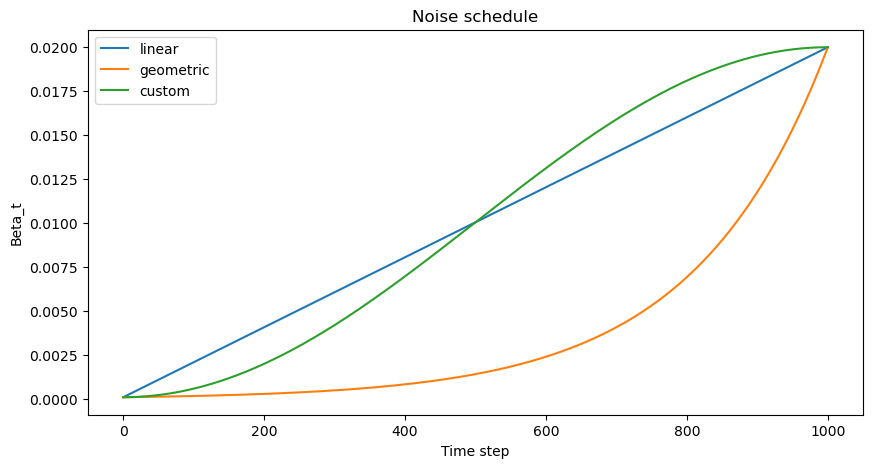

In [4]:
# Below are the functions to generate the noise schedules for the DDPM model


def ddpm_lin_schedule(beta1: float, beta2: float, T: int) -> Dict[str, torch.Tensor]:
    """Returns pre-computed schedules for DDPM sampling with a linear noise schedule."""

    # beta1 and beta2 are the start and end values of the noise schedule
    # T is the number of steps in the schedule
    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1  # Linear schedule
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}


# Defining a geometric noise schedule

def ddpm_geo_schedule(beta1: float, beta2: float, T:int) -> Dict[str, torch.Tensor]:
    """ Generates pre-computed schedules for DDPM sampling with a geometric noise schedule

    Args:
        beta1 (float): The start value of the noise schedule
        beat2 (float): The end value of the noise schedule
        T (int): Number of steps in the schedule

    Returns:
        Dict[str, torch.Tensor]: Pre-computed schedules for DDPM sampling with a geometric noise schedule
    """

    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"

    beta_t = beta1 * (beta2 / beta1) ** (torch.arange(0, T + 1, dtype=torch.float32) / T)  # Geometric schedule
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))  # Cumprod in log-space (better precision)

    return {"beta_t": beta_t, "alpha_t": alpha_t}

# Defining my own noise schedule (Small rate first --> Fast rate --> Small rate) Just like the learning rate schedule
def ddpm_custom_schedule(beta1: float, beta2: float, T:int) -> Dict[str, torch.Tensor]:
    """
    This function attempts to define a cosine noise schedule for DDPM sampling

    Args:
        beta1 (float): The start value of the noise schedule
        beta2 (float): The end value of the noise schedule
        T (int): Number of steps in the schedule

    Returns:
        Dict[str, torch.Tensor]:  Pre-computed schedules for DDPM sampling with a geometric noise schedule
    """

    assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"


    t = torch.linspace(0, 1, T + 1, dtype=torch.float32)  # Normalized time from 0 to 1
    beta_t = ((beta2 - beta1) * 0.5) * (1 - torch.cos(t * np.pi)) + beta1  # Cumprod in log-space (better precision)
    alpha_t = torch.exp(torch.cumsum(torch.log(1 - beta_t), dim=0))

    return {"beta_t": beta_t, "alpha_t": alpha_t}


# Plot beta_t's for different schedules
T = 1000
schedules = {
    "linear": ddpm_lin_schedule(1e-4, 0.02, T),
    "geometric": ddpm_geo_schedule(1e-4, 0.02, T),
    "custom": ddpm_custom_schedule(1e-4, 0.02, T),
}

plt.figure(figsize=(10, 5))
for name, schedule in schedules.items():
    plt.plot(schedule["beta_t"], label=name)
plt.xlabel("Time step")
plt.ylabel("Beta_t")
plt.title("Noise schedule")
plt.legend()
plt.show()




Next, we create a simple 2D convolutional neural network. This network
is essentially going to try to estimate the diffusion process --- we
can then use this network to generate realistic images.

First, we create a single CNN block which we will stack to create the
full network. We use `LayerNorm` for stable training and no batch dependence.

In [5]:
class CNNBlock(nn.Module):
    def __init__(   #constructor
        self,
        in_channels,  # Number of input channels -- depth (e.g. 3 for an RGB image, 1 for a grayscale image)
        out_channels,  # Number of output channels -- also the number of kernels in the convolutional layer
        *,
        expected_shape,  # Dimensions of the input tensor (e.g. (3, 64, 64) for an RGB image with size 64x64)
        act=nn.GELU,
        kernel_size=7,  # Size of the kernel, square kernel is assumed
    ):
        super().__init__()  # Initialize the parent class

        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.LayerNorm((out_channels, *expected_shape)),
            act()  # Activation function -- GELU
        )

    def forward(self, x):
        return self.net(x)

We then create the full CNN model, which is a stack of these blocks
according to the `n_hidden` tuple, which specifies the number of
channels at each hidden layer.

In [7]:
class CNN(nn.Module):
    def __init__(
        self,
        in_channels,
        expected_shape=(28, 28),  # Dimensions of the input tensor for MNIST images
        n_hidden=(64, 128, 64),   # Number of output channels at each hidden layer
        kernel_size=7,
        last_kernel_size=3,
        time_embeddings=16,
        act=nn.GELU,
    ) -> None:
        super().__init__()
        last = in_channels

        self.blocks = nn.ModuleList() # List of CNN blocks
        for hidden in n_hidden:
            self.blocks.append(
                CNNBlock(
                    last,  # Number of input channels
                    hidden,
                    expected_shape=expected_shape,
                    kernel_size=kernel_size,
                    act=act,
                )
            )
            last = hidden  # Update the number of input channels for the next layer --> output for previous layer is input for next layer

        # The final layer, we use a regular Conv2d to get the
        # correct scale and shape (and avoid applying the activation)
        self.blocks.append(  # Append the final layer to the list of CNN blocks
            nn.Conv2d(  # Output layer should match the input layer
                last,
                in_channels,
                last_kernel_size,
                padding=last_kernel_size // 2,
            )
        )

        ## This part is literally just to put the single scalar "t" into the CNN
        ## in a nice, high-dimensional way:
        self.time_embed = nn.Sequential(
            nn.Linear(time_embeddings * 2, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, 128), act(),
            nn.Linear(128, n_hidden[0]),
        )
        frequencies = torch.tensor(
            [0] + [2 * np.pi * 1.5**i for i in range(time_embeddings - 1)]
        )
        self.register_buffer("frequencies", frequencies)

    def time_encoding(self, t: torch.Tensor) -> torch.Tensor:
        phases = torch.concat(
            (
                torch.sin(t[:, None] * self.frequencies[None, :]),
                torch.cos(t[:, None] * self.frequencies[None, :]) - 1,
            ),
            dim=1,
        )

        return self.time_embed(phases)[:, :, None, None]

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # Shapes of input:
        #    x: (batch, chan, height, width)
        #    t: (batch,)

        embed = self.blocks[0](x)  # Apply the first CNN block
        # ^ (batch, n_hidden[0], height, width)

        # Add information about time along the diffusion process
        #  (Providing this information by superimposing in latent space)
        embed += self.time_encoding(t)
        #         ^ (batch, n_hidden[0], 1, 1) - thus, broadcasting
        #           to the entire spatial domain

        for block in self.blocks[1:]:  # Apply the remaining CNN blocks (2 and 3 in this case)
            embed = block(embed)

        return embed

Next, we define the actual diffusion model, which specifies the training
schedule, takes an arbitrary model for estimating the
diffusion process (such as the CNN above),
and computes the corresponding loss (as well as generating samples).

In [8]:
class DDPM(nn.Module):
    def __init__(
        self,
        gt,  # The model to predict the noide at each step
        betas: Tuple[float, float],  # Start and end values of the noise schedule
        n_T: int,   # Number of steps in diffusion process.
        criterion: nn.Module = nn.MSELoss(),  # Loss function to use during training
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_lin_schedule(betas[0], betas[1], n_T)  # Pre-computed schedule dictionary for DDPM sampling

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])  # Buffers are like parameters, but not updated by optimizer
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t

        self.n_T = n_T
        self.criterion = criterion

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Algorithm 18.1 in Prince"""

        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)
        eps = torch.randn_like(x)  # eps ~ N(0, 1)
        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting

        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:

                z_t += torch.sqrt(beta_t) * torch.randn_like(z_t)
            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t

In [ ]:
# Custom degradation method for MNIST
# The strategy is to add noise  proportional to the local entropy of the image
# This is a simple way to simulate a more realistic degradation process

class DES(nn.Module):
    def __init__(
        self,
        gt,  # The model to predict the noide at each step
        betas: Tuple[float, float],  # Start and end values of the noise schedule
        n_T: int,   # Number of steps in diffusion process.
        criterion: nn.Module = nn.MSELoss(),  # Loss function to use during training
        window_size: int = 3,
    ) -> None:
        super().__init__()

        self.gt = gt

        noise_schedule = ddpm_lin_schedule(betas[0], betas[1], n_T)  # Pre-computed schedule dictionary for DDPM sampling

        # `register_buffer` will track these tensors for device placement, but
        # not store them as model parameters. This is useful for constants.
        self.register_buffer("beta_t", noise_schedule["beta_t"])  # Buffers are like parameters, but not updated by optimizer
        self.beta_t  # Exists! Set by register_buffer
        self.register_buffer("alpha_t", noise_schedule["alpha_t"])
        self.alpha_t

        self.n_T = n_T
        self.criterion = criterion
        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:


        t = torch.randint(1, self.n_T, (x.shape[0],), device=x.device)

        alpha_t = self.alpha_t[t, None, None, None]  # Get right shape for broadcasting

        # Calculate local entropy
        entropy = self.compute_entropy(x, bins=256)

        # Pass the entropy through sigmoid to get a value between 0 and 1
        entropy = torch.sigmoid(entropy)


        # Combine entropy with noise (eps)
        eps = torch.randn_like(x) * entropy


        z_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * eps
        # This is the z_t, which is sqrt(alphabar) x_0 + sqrt(1-alphabar) * eps
        # We should predict the "error term" from this z_t. Loss is what we return.

        return self.criterion(eps, self.gt(z_t, t / self.n_T))

    def compute_entropy(self, x: torch.Tensor, bins: int = 256) -> torch.Tensor:

         # Flatten the batch of images to a single dimension for histogram calculation
        img_flat = x.flatten()

        # Calculate the histogram for the entire batch
        hist = torch.histc(img_flat, bins=bins, min=x.min(), max=x.max())

        # Normalize the histogram to form a probability distribution function (PDF)
        pdf = hist / hist.sum()

        # Replace zeros with small positive values to avoid log(0)
        pdf = torch.clamp(pdf, min=1e-6)

        # Calculate entropy for the batch
        entropy = -(pdf * torch.log2(pdf)).sum()

        return entropy.unsqueeze(0)  # Return as a tensor with a single value


    def sample(self, n_sample: int, size, device) -> torch.Tensor:
        """Algorithm 18.2 in Prince"""

        _one = torch.ones(n_sample, device=device)
        z_t = torch.randn(n_sample, *size, device=device)
        for i in range(self.n_T, 0, -1):
            alpha_t = self.alpha_t[i]
            beta_t = self.beta_t[i]

            entropy = self.compute_entropy(z_t, bins=256)
            # Pass the entropy through sigmoid to get a value between 0 and 1
            entropy = torch.sigmoid(entropy)


            # First line of loop:
            z_t -= (beta_t / torch.sqrt(1 - alpha_t)) * self.gt(z_t, (i/self.n_T) * _one)
            z_t /= torch.sqrt(1 - beta_t)

            if i > 1:
                z_t += torch.sqrt(beta_t) * ((torch.randn_like(z_t))*entropy)

            # (We don't add noise at the final step - i.e., the last line of the algorithm)

        return z_t



We will run this on MNIST. We perform some basic preprocessing, and set up the data loader:

In [11]:
tf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0))])
training_dataset = MNIST("./data", train=True, download=True, transform=tf)
training_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True, num_workers=4, drop_last=True)


60000


In [12]:
# Creating a validation dataset

validation_dataset = MNIST("./data", train=False, download=True, transform=tf)
validation_dataloader = DataLoader(validation_dataset, batch_size=128, shuffle = True, num_workers=4, drop_last=True)


10000


We create our model with a given choice of hidden layers and activation function. We also choose a learning rate.

In [13]:
# Here choose the model to use for training
# "ddpm" for the default model
# "ddpm_capacity" for a model with more capacity
# "des" for the model with the custom degradation method

gt = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(16, 32, 32, 16), act=nn.GELU)  #gray scale image
gt_capacity = CNN(in_channels=1, expected_shape=(28, 28), n_hidden=(64, 128, 256, 128, 64), act=nn.GELU)  #gray scale image

ddpm = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
ddpm_capacity = DDPM(gt=gt_capacity, betas=(1e-4, 0.02), n_T=1000)
des = DES(gt=gt, betas=(1e-4, 0.02), n_T = 1000)


# Also, choose the model to use for training, adjust the model here as well
optim = torch.optim.Adam(ddpm.parameters(), lr=2e-4)

We could set up a GPU if we have one, which is done below.

Here, we use HuggingFace's `accelerate` library, which abstracts away all the `.to(device)` calls for us.
This lets us focus on the model itself rather than data movement.
It also does a few other tricks to speed up calculations.

PyTorch Lightning, which we discussed during the course, is another option that also handles a lot more, but is a bit heavyweight.
`accelerate` is a simpler option closer to raw PyTorch.
However, if you prefer, you could choose to use Lightning for the coursework!

In [14]:
accelerator = Accelerator()

# We wrap our model, optimizer, and dataloaders with `accelerator.prepare`,
# which lets HuggingFace's Accelerate handle the device placement and gradient accumulation.
ddpm, optim, training_dataloader = accelerator.prepare(ddpm, optim, training_dataloader)
validation_dataloader = accelerator.prepare(validation_dataloader)

First, let's just make sure this works:

In [15]:
for x, _ in training_dataloader:
    
    break

with torch.no_grad():
    ddpm(x)

/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <85A36C65-3F71-3C3B-B529-961AE17DBE73> /Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <44DEDA27-4DE9-3D4A-8EDE-5AA72081319F> /Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to

KeyboardInterrupt: 

Now, let's train it. You can exit early by interrupting the kernel. Images
are saved to the `contents` folder.

In [136]:
# Defining a PSNR function here

def psnr(x: torch.Tensor, y: torch.Tensor, data_range: float) -> torch.Tensor:
    mse = torch.mean((x - y) ** 2)
    if mse == 0:
        return torch.tensor(float('inf'))
    return 20 * torch.log10(data_range / torch.sqrt(mse))


In [137]:
n_epoch = 50
training_losses = []
validation_losses = []
epoch_ssim_scores = []
epoch_psnr_scores = []


for i in range(n_epoch):  # Loop over the epochs
    ddpm.train()  # Set the model to training mode


    pbar = tqdm(training_dataloader)  # Wrap our loop with a visual progress bar
    for x, _ in pbar:  # Loop over the #batches = len(training_dataloader) --> 128 images per batch
        optim.zero_grad()  # Clear gradients before each step

        train_loss = ddpm(x)  # Forward pass to calculate the loss

        training_losses.append(train_loss.item())


        train_loss.backward()
        # ^Technically should be `accelerator.backward(loss)` but not necessary for local training

        avg_loss = np.average(training_losses[min(len(training_losses)-100, 0):])
        pbar.set_description(f"loss: {avg_loss:.3g}")  # Show running average of loss in progress bar

        optim.step()  # Update the model's parameters based on the calculated gradients



    ddpm.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # No need to calculate gradients when evaluating the model

        #_______________________Sample after each epoch______________

        # Generate 100 samples after each epoch
        xh = ddpm.sample(16, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
        grid = make_grid(xh, nrow=4)


        # Save samples to `./contents` directory
        save_image(grid, f"./contents/ddpm_sample_{i:04d}.png")

        # save model
        torch.save(ddpm.state_dict(), f"./ddpm_mnist.pth")


        #_____________________Validation phase_____________________
        val_batch_iteration = 0
        for x_val, _ in validation_dataloader:  # Loading in batches for memory efficiency
            val_batch_iteration += 1
            val_loss = ddpm(x_val)  # Forward pass on validation batch
            validation_losses.append(val_loss.item())

            if val_batch_iteration == 1:
              validation_images = x_val[:16].to(accelerator.device)  # Sample 16 images for the score calculations


        #_____________________SSIM/PSNR Scores____________________________

        # Calculating the SSIM score between samples and validation images

        # Using the 16 generated samples from the model
        generated_images = xh

        # Calculating the SSIM score for each generated image across 100 validation images and taking the average

        individual_ssim_scores = []
        individual_psnr_scores = []
        for gen_image in xh:
            gen_image = gen_image.unsqueeze(0)  # Add a batch dimension to the generated image

            ssim_score_single_gen_im = []
            psnr_score_single_gen_im = []
            for val_image in validation_images:
                val_image = val_image.unsqueeze(0)

                ssim_score = ssim(gen_image, val_image, data_range = 1.0, size_average=True)
                ssim_score_single_gen_im.append(ssim_score.item())

                psnr_score = psnr(gen_image, val_image, data_range = 1.0)
                psnr_score_single_gen_im.append(psnr_score.item())


            # Calculate the average SSIM score for this generated image against the 100 validation images
            avg_ssim = torch.tensor(ssim_score_single_gen_im).mean()
            individual_ssim_scores.append(avg_ssim.item())

            # Calculate the average PSNR score for this generated image against the 100 validation images
            avg_psnr = torch.tensor(psnr_score_single_gen_im).mean()
            individual_psnr_scores.append(avg_psnr.item())


        # Calculate the overall average SSIM score for this epoch (average of 100 generated images)
        epoch_avg_ssim = np.mean(individual_ssim_scores)
        epoch_ssim_scores.append(epoch_avg_ssim)

        # Calculate the overall average PSNR score for this epoch (average of 100 generated images)
        epoch_avg_psnr = np.mean(individual_psnr_scores)
        epoch_psnr_scores.append(epoch_avg_psnr)

NameError: name 'ddpm' is not defined

mv: rename ddpm_mnist.pth to ./contents/ddpm_mnist.pth: No such file or directory


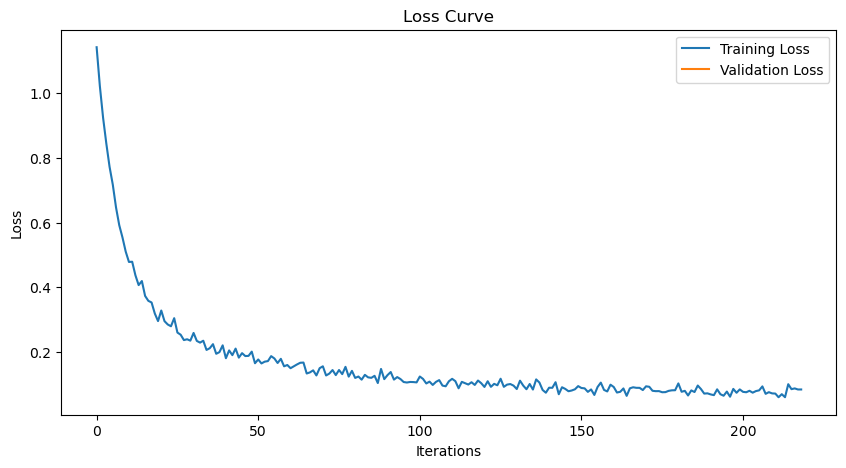

In [16]:
# Move the saved model to the `./contents` directory
!mv ddpm_mnist.pth ./contents/ddpm_mnist.pth


# Save the training and validation losses to the `./contents` directory
np.save("./contents/training_losses.npy", training_losses)
np.save("./contents/validation_losses.npy", validation_losses)

# Save the SSIM scores to the `./contents` directory
np.save("./contents/epoch_ssim_scores.npy", epoch_ssim_scores)
# Save the PSNR scores to the `./contents` directory
np.save("./contents/epoch_psnr_scores.npy", epoch_psnr_scores)



# Plotting the loss curve and validation curve as a function of the number of iterations

plt.figure(figsize=(10,5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Save the plot to the `./contents` directory
plt.savefig("./contents/loss_curve.png")

plt.show()


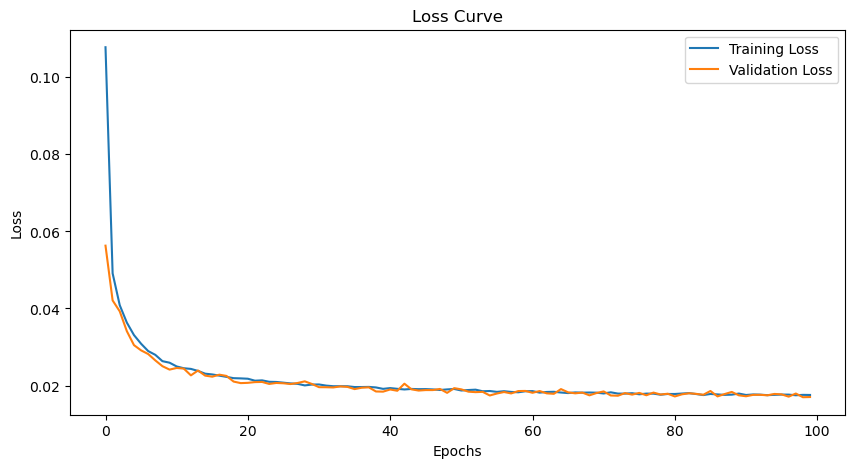

In [85]:
# Open the training_losses.npy and validation_losses.npy files and plot the loss curves
training_losses = np.load("./contents_all/training_losses.npy")
n_batches_training = 468

validation_losses = np.load("./contents_all/validation_losses.npy")
n_batches_validation = 78

# Average the losses per epoch -- for training 468 batches per epoch
training_losses = training_losses.reshape(-1, n_batches_training).mean(axis=1)

# Average the losses per epoch -- for validation 78 batches per epoch
validation_losses = validation_losses.reshape(-1, n_batches_validation).mean(axis=1)


# Plotting the loss curve and validation curve as a function of the number of iterations
plt.figure(figsize=(10,5))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()


# Save the plot to the `./plots` directory
plt.savefig("./plots/main_loss_curve_50epochs.png")

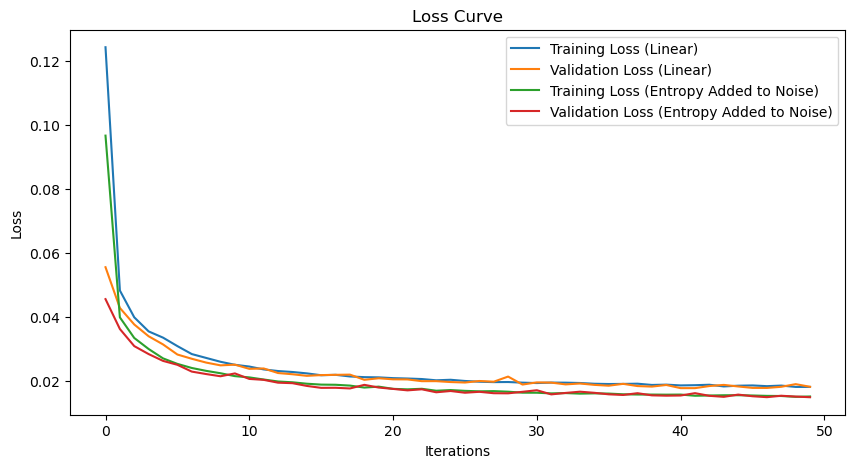

In [29]:
# Plotting the loss curve and validation curve for default model and model with custom degradation method



# Average the losses per epoch -- for training 468 batches per epoch
n_batches_training = 468
n_batches_validation = 78

training_losses_linear = np.load("./contents_lin/training_losses.npy")
training_losses_linear = training_losses_linear.reshape(-1, n_batches_training).mean(axis=1)

training_losses_geo = np.load("./contents_geo/training_losses.npy")
training_losses_geo = training_losses_geo.reshape(-1, n_batches_training).mean(axis=1)

training_losses_custom = np.load("./contents_custom/training_losses.npy")
training_losses_custom = training_losses_custom.reshape(-1, n_batches_training).mean(axis=1)

validation_losses_linear = np.load("./contents_lin/validation_losses.npy")
validation_losses_linear = validation_losses_linear.reshape(-1, n_batches_validation).mean(axis=1)

validation_losses_geo = np.load("./contents_geo/validation_losses.npy")
validation_losses_geo = validation_losses_geo.reshape(-1, n_batches_validation).mean(axis=1)

validation_losses_custom = np.load("./contents_custom/validation_losses.npy")
validation_losses_custom = validation_losses_custom.reshape(-1, n_batches_validation).mean(axis=1)

validation_losses_entropy = np.load("./contents_entropy/validation_losses.npy")
validation_losses_entropy = validation_losses_entropy.reshape(-1, n_batches_validation).mean(axis=1)
training_losses_entropy = np.load("./contents_entropy/training_losses.npy")
training_losses_entropy = training_losses_entropy.reshape(-1, n_batches_training).mean(axis=1)

validation_loss_largen_hidden = np.load("./contents_custom_largen_hidens/validation_losses.npy")
validation_loss_largen_hidden = validation_loss_largen_hidden.reshape(-1, n_batches_validation).mean(axis=1)
training_loss_largen_hidden = np.load("./contents_custom_largen_hidens/training_losses.npy")
training_loss_largen_hidden = training_loss_largen_hidden.reshape(-1, n_batches_training).mean(axis=1)



plt.figure(figsize=(10,5))

#plt.plot(training_loss_largen_hidden, label="Training Loss (Large n_hidden)")
#plt.plot(validation_loss_largen_hidden, label="Validation Loss (Large n_hidden)")

plt.plot(training_losses_linear, label="Training Loss (Linear)")
plt.plot(validation_losses_linear, label="Validation Loss (Linear)")

#plt.plot(training_losses_geo, label="Training Loss (Geometric)")
#plt.plot(validation_losses_geo, label="Validation Loss (Geometric)")

#plt.plot(training_losses_custom, label="Training Loss (Custom)")
#plt.plot(validation_losses_custom, label="Validation Loss (Custom)")

plt.plot(training_losses_entropy, label="Training Loss (Entropy Added to Noise)")
plt.plot(validation_losses_entropy, label="Validation Loss (Entropy Added to Noise)")

plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()



# Save the plot to the `./plots` directory
plt.savefig("./plots/loss_curve_linear_geo_custom.png")

plt.show()


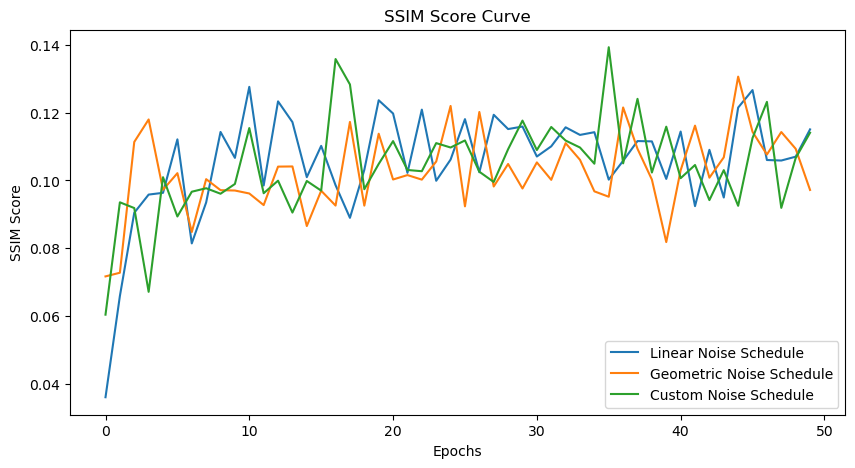

In [23]:
# Extracting the SSIM scores from the `./contents` directory
ssim_scores_linear = np.load("./contents_lin/epoch_ssim_scores.npy")
ssim_scores_geometric = np.load("./contents_geo/epoch_ssim_scores.npy")
ssim_scores_custom = np.load("./contents_custom/epoch_ssim_scores.npy")

# Plotting the SSIM scores for the linear and geometric noise schedules
plt.figure(figsize=(10,5))
plt.plot(ssim_scores_linear, label="Linear Noise Schedule")
plt.plot(ssim_scores_geometric, label="Geometric Noise Schedule")
plt.plot(ssim_scores_custom, label="Custom Noise Schedule")
plt.xlabel("Epochs")
plt.ylabel("SSIM Score")
plt.title("SSIM Score Curve")
plt.legend()

# Save the plot to the `./plots` directory
plt.savefig("./plots/ssim_score_curve.png")

plt.show()



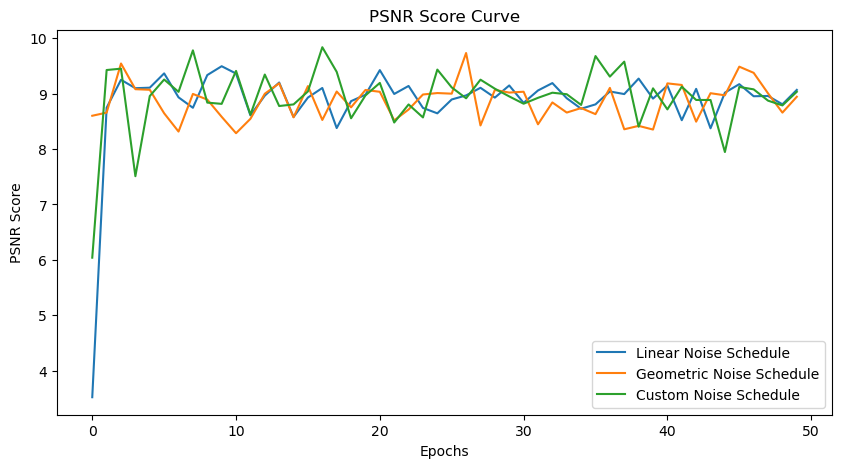

In [24]:
# Extracting the PSNR scores from the `./contents` directory
psnr_scores_linear = np.load("./contents_lin/epoch_psnr_scores.npy")
psnr_scores_geometric = np.load("./contents_geo/epoch_psnr_scores.npy")
psnr_scores_custom = np.load("./contents_custom/epoch_psnr_scores.npy")

# Plotting the PSNR scores for the linear, geometric, and costume noise schedules
plt.figure(figsize=(10,5))
plt.plot(psnr_scores_linear, label="Linear Noise Schedule")
plt.plot(psnr_scores_geometric, label="Geometric Noise Schedule")
plt.plot(psnr_scores_custom, label="Custom Noise Schedule")
plt.xlabel("Epochs")
plt.ylabel("PSNR Score")
plt.title("PSNR Score Curve")
plt.legend()

# Save the plot to the `./plots` directory
plt.savefig("./plots/psnr_score_curve.png")

plt.show()



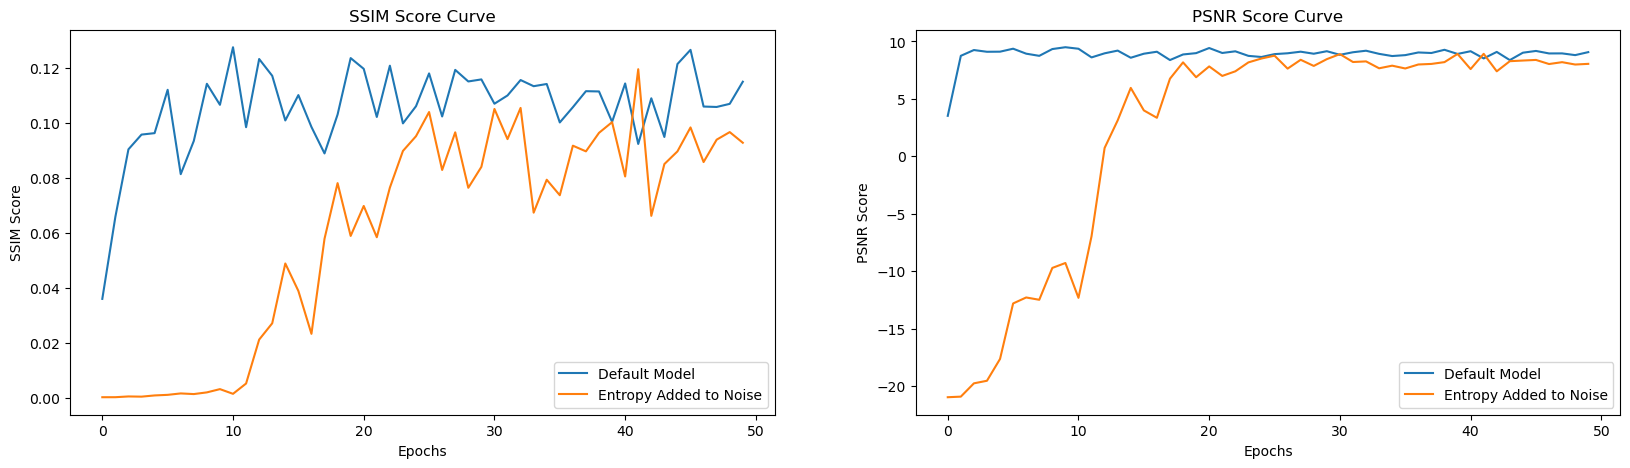

In [30]:
# Plotting the SSIM and PSNR scores for the linear and largen_hidden data

ssim_scores_largen_hidden = np.load("./contents_entropy/epoch_ssim_scores.npy")
psnr_scores_largen_hidden = np.load("./contents_entropy/epoch_psnr_scores.npy")

# Create a figure with two subplots, side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5)) # figsize is in inches

# Plot the SSIM scores on the first subplot
ax1.plot(ssim_scores_linear, label="Default Model")
ax1.plot(ssim_scores_largen_hidden, label="Entropy Added to Noise")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("SSIM Score")
ax1.set_title("SSIM Score Curve")
ax1.legend()

# Plot the PSNR scores on the second subplot
ax2.plot(psnr_scores_linear, label="Default Model")
ax2.plot(psnr_scores_largen_hidden, label="Entropy Added to Noise")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("PSNR Score")
ax2.set_title("PSNR Score Curve")
ax2.legend()

# Save the entire figure to the `./plots` directory
plt.savefig("./plots/scores_curves_capacity.png")

# Show the plots
plt.show()


In [31]:
#######FID CALCULATION########

from torchvision.models import inception_v3
import torch
from scipy.linalg import sqrtm
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

# Load a pre-trained image classifier: InceptionV3 model
model = inception_v3(pretrained=True, transform_input=False).to(accelerator.device)
# Remove the final fully connected layer -- we don't need the classification
model.fc = torch.nn.Identity()  

model.eval()

# Define a feature extraction function
def get_features(model, dataloader):
    features = []
    
    # Defining a transformation pipeline to preprocess the images
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # Resize the image to 299x299
        transforms.Normalize((0.486, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet normalization
    ])
    for image in dataloader:  # Make sure images have batch dimension

        image = image[0]

        image = image.repeat(1, 3, 1, 1)  # Repeat the grayscale image to create 3 channels
        
        transformed_images = torch.stack([transform(img) for img in image])  # Apply the transformation pipeline to the images

        transformed_images = transformed_images.to(accelerator.device)  # Move the images to the device
        

        # Extract the features from pool3 layer of the InceptionV3 model
        
        with torch.no_grad():
            pool3_features = model(transformed_images)
            features.append(pool3_features.detach())
    return torch.cat(features)


def calculate_fid(real_features, generated_features):


    # Move the features to the device
    real_features = real_features.to(accelerator.device)
    generated_features = generated_features.to(accelerator.device)
    
    # Calculate the mean of the real and generated features
    mu_real = real_features.mean(dim=0)
    mu_generated = generated_features.mean(dim=0)
    
    # Calculate the covariance matrix of the real and generated features
    sigma_real = (real_features - mu_real).T @ (real_features - mu_real)
    sigma_real = sigma_real / (real_features.shape[0] - 1)  # Unbiased estimator 1/(N-1)
    sigma_generated = (generated_features - mu_generated).T @ (generated_features - mu_generated)
    sigma_generated = sigma_generated / (generated_features.shape[0] - 1)  # Unbiased estimator 1/(N-1)
    

     # Check for NaN or inf values in the covariance matrices
    if torch.isnan(sigma_real).any() or torch.isinf(sigma_real).any() or \
       torch.isnan(sigma_generated).any() or torch.isinf(sigma_generated).any():
        raise ValueError("Covariance matrices contain NaNs or infs")


    # Convert covariance matricies to numpy array
    sigma_real_np = sigma_real.cpu().numpy()
    sigma_generated_np = sigma_generated.cpu().numpy()
    
    # Calculate the squared root of the product of the covariance matrices
    sigma_root_np = sqrtm(sigma_real_np.dot(sigma_generated_np))
    if np.iscomplexobj(sigma_root_np):
        sigma_root_np = np.real(sigma_root_np)  # Only the real part is needed
        
    # Convert the arrays back to a tensor and move it back to the device
    sigma_root = torch.from_numpy(sigma_root_np).to(accelerator.device)
    
    # Calculate the FID score
    fid = torch.norm(mu_real - mu_generated)**2 + torch.trace(sigma_real + sigma_generated - 2 * sigma_root)
    return fid.item()


# Loading the trained model from the contents_lin directory
ddpm_lin = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
ddpm_lin.load_state_dict(torch.load("./contents_lin/ddpm_mnist_lin.pth", map_location=accelerator.device))
ddpm_lin.eval()

# Loading the trained model from the contents_geo directory
ddpm_geo = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
ddpm_geo.load_state_dict(torch.load("./contents_geo/ddpm_mnist_geo.pth", map_location=accelerator.device))
ddpm_geo.eval()

# Loading the trained model from the contents_custom directory
ddpm_custom = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
ddpm_custom.load_state_dict(torch.load("./contents_custom/ddpm_mnist_custom.pth", map_location=accelerator.device))
ddpm_custom.eval()

# Loading the trained model from the contents_custom_largen_hidens directory
ddpm_largen_hidden = DDPM(gt=gt, betas=(1e-4, 0.02), n_T=1000)
ddpm_largen_hidden.load_state_dict(torch.load("./contents_custom_largen_hidens/ddpm_mnist_capacity.pth", map_location=accelerator.device))
ddpm_largen_hidden.eval()

# Loading the trained model from the contents_entropy directory
des = DES(gt=gt, betas=(1e-4, 0.02), n_T=1000)
des.load_state_dict(torch.load("./contents_entropy/ddpm_mnist_entropy.pth", map_location=accelerator.device))
des.eval()


# Generate 1,000 images from the fully trained models
with torch.no_grad():
    generated_samples_lin = ddpm_lin.sample(1000, (1, 28, 28), accelerator.device)  # Can get device explicitly with `accelerator.device`
    generated_samples_lin = TensorDataset(generated_samples_lin)
    generated_samples_geo = ddpm_geo.sample(1000, (1, 28, 28), accelerator.device)
    generated_samples_geo = TensorDataset(generated_samples_geo)
    generated_samples_custom = ddpm_custom.sample(1000, (1, 28, 28), accelerator.device) 
    generated_samples_custom = TensorDataset(generated_samples_custom)
    generated_samples_largen_hidden = ddpm_largen_hidden.sample(1000, (1, 28, 28), accelerator.device)
    generated_samples_largen_hidden = TensorDataset(generated_samples_largen_hidden)
    generated_samples_entropy = des.sample(1000, (1, 28, 28), accelerator.device)
    generated_samples_entropy = TensorDataset(generated_samples_entropy)    
    
# Generate 1,000 images from the validation set
reference_images = next(iter(validation_dataloader))[0][:1000]
reference_images = TensorDataset(reference_images)

# Create a dataloader for the generated samples and the reference images
generated_dataloader_lin = DataLoader(generated_samples_lin, batch_size=100, shuffle=False)
generated_dataloader_geo = DataLoader(generated_samples_geo, batch_size=100, shuffle=False)
generated_dataloader_custom = DataLoader(generated_samples_custom, batch_size=100, shuffle=False)
generated_dataloader_largen_hidden = DataLoader(generated_samples_largen_hidden, batch_size=100, shuffle=False)
generated_dataloader_entropy = DataLoader(generated_samples_entropy, batch_size=100, shuffle=False)
reference_data_loader = DataLoader(reference_images, batch_size=100, shuffle=False)



# Extract the features from the InceptionV3 model
real_features = get_features(model, reference_data_loader)
generated_features_lin = get_features(model, generated_dataloader_lin)
generated_features_geo = get_features(model, generated_dataloader_geo)
generated_features_custom = get_features(model, generated_dataloader_custom)
generated_features_largen_hidden = get_features(model, generated_dataloader_largen_hidden)
generated_features_entropy = get_features(model, generated_dataloader_entropy)

# Calculate the FID score for the linear noise schedule
fid_lin = calculate_fid(real_features, generated_features_lin)
print(f"The FID score for the linear noise schedule is: {fid_lin:.3f}")

# Calculate the FID score for the geometric noise schedule
fid_geo = calculate_fid(real_features, generated_features_geo)
print(f"The FID score for the geometric noise schedule is: {fid_geo:.3f}")

# Calculate the FID score for the custom noise schedule
fid_custom = calculate_fid(real_features, generated_features_custom)
print(f"The FID score for the custom noise schedule is: {fid_custom:.3f}")

# Calculate the FID score for the increased CNN capacity
fid_capacity = calculate_fid(real_features, generated_features_largen_hidden)
print(f"The FID score for the increased CNN capacity is: {fid_capacity:.3f}")

# Calculate the FID score for the entropy added to noise
fid_entropy = calculate_fid(real_features, generated_features_entropy)
print(f"The FID score for the entropy added to noise is: {fid_entropy:.3f}")







/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mertdaloglu/anaconda3/envs/project/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /Users/mertdaloglu/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:28<00:00, 3.82MB/s] 


FileNotFoundError: [Errno 2] No such file or directory: './ddpm_mnist_lin.pth'

In [ ]:
# Make a table for the FID scores

# Create a dictionary of the FID scores
fid_scores = {
    "Linear Noise Schedule": fid_lin,
    "Geometric Noise Schedule": fid_geo,
    "Custom Noise Schedule": fid_custom,
    "Increased CNN Capacity": fid_capacity,
    "Entropy Added to Noise": fid_entropy
}

pd.DataFrame(fid_scores, index=["FID Score"])

# Save the FID scores to the `./contents` directory
pd.DataFrame(fid_scores, index=["FID Score"]).to_csv("./contents/fid_scores.csv")

